In [6]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
sns.set_style('darkgrid')

# Background 

TalkingData, China's largest third-party mobile data platform wanted to use their data to help its clients better understand and interact with their indivudal audiences. Contained within this file of folders include individual csv files that includes a file based on user's age and gender, a file for the phone brands of the users, a file for the user's location, a file for when a user uses TalkingData SDK, the event gets logged in this data which also contains the user's location data, and a file for the name of the apps that a user uses. 

This is one of the bigger data sets which contain 1.28 gigabits worth of information. The data set can be foudn here on kaggle: https://www.kaggle.com/c/talkingdata-mobile-user-demographics

# Project Goal:

Given the data sets that I have access to, I want to use the gender, age, type of device, and which phone a user has in order to accurately classify and predict the age range and gender of that individual. This is valuable being able to correctly identify the characteristics of one's audience can save financial resources since a company can focus their resources on a more specific target given this information. Furthermore, advertising can become more personalized and perhaps knowing the user's details can help with building a better recommendation engine whether it be in ads or a similar concept like Netflix show recommendations as an example. 

In [7]:
# Load up the data.
#ga stands for gender/age
ga_train = pd.read_csv('gender_age_train.csv')
ga_test = pd.read_csv('gender_age_test.csv' )
# 
phone_brands = pd.read_csv('phone_brand_device_model.csv')
# Get rid of duplicate device ids in phone
phone_brands = phone_brands.drop_duplicates('device_id',keep='first')
# Location data
events = pd.read_csv('events.csv', usecols = ['event_id', 'device_id'])
app_events = pd.read_csv('app_events.csv', usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
app_labels = pd.read_csv('app_labels.csv')
label_cats = pd.read_csv('label_categories.csv', index_col='label_id',squeeze=True)

# Exploratory Data Analysis

In [3]:
print('Shape of ga_train data set:')
print(ga_train.shape)
ga_train.head()

Shape of ga_train data set:
(74645, 4)


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


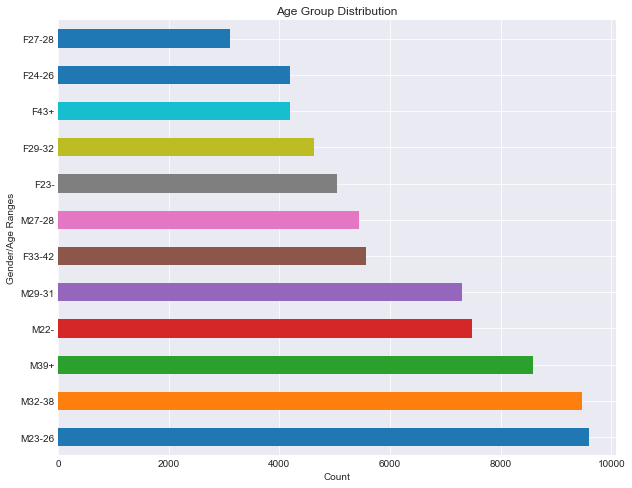

In [4]:
# Distribution of age based users.
fig,ax = plt.subplots(figsize=(10,8))
ga_train.group.value_counts().plot(kind='barh')
plt.title('Age Group Distribution')
plt.ylabel('Gender/Age Ranges')
plt.xlabel('Count');

From this horizontal bar graph, we can see that most of the users happen to be young adult males, but we can do better than eyeball from this graph. 

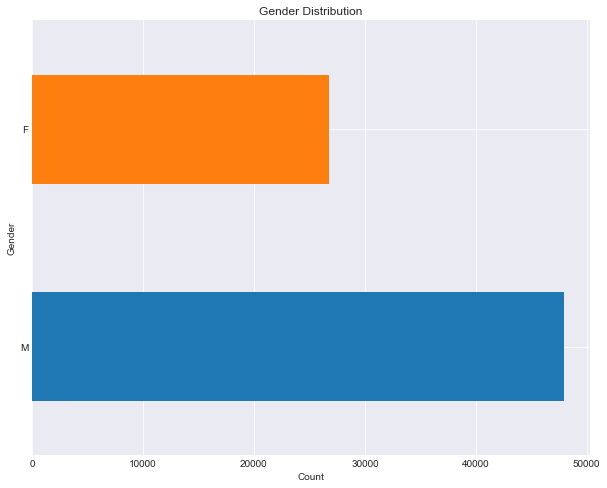

In [5]:
# Gender Distribution
fig,ax = plt.subplots(figsize=(10,8))
ga_train.gender.value_counts().plot(kind='barh')
plt.title('Gender Distribution')
plt.xlabel('Count')
plt.ylabel('Gender');

This is clear that there are almost double amount of males compared to the amount of females. 

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


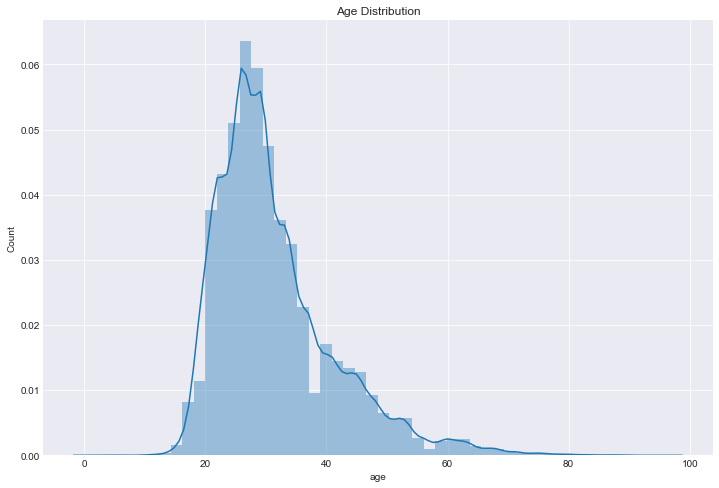

In [6]:
# Age Distribution
fig,ax = plt.subplots(figsize=(12,8))
plt.title('Age Distribution')
plt.xlabel('Ages')
plt.ylabel('Count')
sns.distplot(ga_train.age);

In [7]:
print('Shape of phone brands data set:')
print(phone_brands.shape)
phone_brands.head()

Shape of phone brands data set:
(186716, 3)


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [8]:
print('Number of unique brands:')
print(phone_brands.phone_brand.nunique())

print('\nNumber of unique models:')
print(phone_brands.device_model.nunique())

Number of unique brands:
131

Number of unique models:
1599


In [9]:
# Check to see if there is over representation of any one brand. 
device_count = phone_brands.groupby(['device_model'])['phone_brand'].apply(pd.Series.nunique)
device_count.value_counts()

1    1545
2      43
3       8
4       3
Name: phone_brand, dtype: int64

In [10]:
# App events overlook
print('shape of events data set:')
print(app_events.shape)
app_events.head(25)

shape of events data set:
(32473067, 3)


,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True
5,2,4775896950989639373,True
6,2,-8022267440849930066,False
7,2,9112463267739110219,False
8,2,-3725672010020973973,False
9,2,7167114343576723123,True


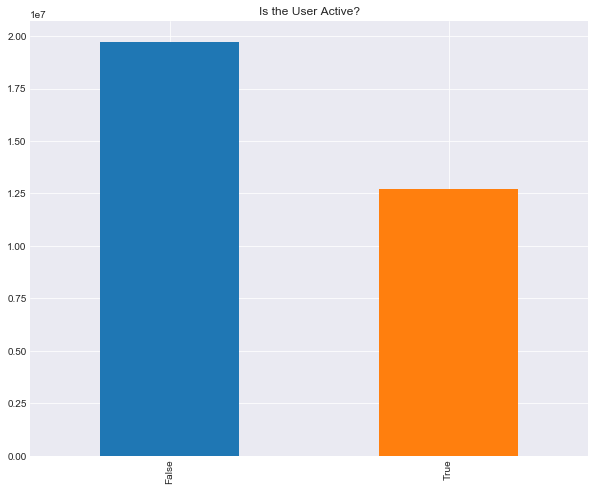

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
plt.title('Is the User Active?')
app_events['is_active'].value_counts().plot(kind='bar');

In [12]:
print('Shape of events:')
print(events.shape)
events.head()

Shape of events:
(3252950, 2)


,event_id,device_id
0,1,29182687948017175
1,2,-6401643145415154744
2,3,-4833982096941402721
3,4,-6815121365017318426
4,5,-5373797595892518570


# Data Exploration (No Graphs)

In [8]:
# Check numerical value of age groups
ga_train.group.value_counts()

M23-26    9605
M32-38    9476
M39+      8581
M22-      7488
M29-31    7309
F33-42    5561
M27-28    5445
F23-      5050
F29-32    4628
F43+      4194
F24-26    4190
F27-28    3118
Name: group, dtype: int64

In [9]:
# Re-import app_events for the binary output of is_active
app_events2 = pd.read_csv('app_events.csv', usecols=['event_id','app_id','is_active'])

In [10]:
device_apps = (
    app_events2
    
     # Merge on event_id
    .merge(events, how = 'left', left_on = 'event_id', right_on = 'event_id')
    
     # event_id itself is not interesting
    .drop('event_id', axis = 1)
    
     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates()
)

# Our data now looks like this
device_apps.head()

,app_id,is_active,device_id
0,5927333115845830913,1,-6401643145415154744
1,-5720078949152207372,0,-6401643145415154744
2,-1633887856876571208,0,-6401643145415154744
3,-653184325010919369,1,-6401643145415154744
4,8693964245073640147,1,-6401643145415154744


In [11]:
device_apps.shape

(2840343, 3)

In [12]:
# Encode the device_model and phone_brand to use as a feature.
phone_brands.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [13]:
# It seems like some brands don't have specific model names.
print('Number of distinct model names: ' + str(phone_brands.groupby(['device_model']).size().shape[0]))
print('Number of distinct brand+model names: ' + str(phone_brands.groupby(['phone_brand','device_model']).size().shape[0]))

Number of distinct model names: 1599
Number of distinct brand+model names: 1667


In [14]:
# Combine the two columns
phone_brands['brand_and_model'] = phone_brands['phone_brand'].astype(str) + phone_brands['device_model']

# Build numerical labels for our models
modelencoder = LabelEncoder().fit(phone_brands['brand_and_model'])

# Store in a new column
phone_brands['encoded_model'] = modelencoder.transform(phone_brands['brand_and_model'])

In [15]:
# Take a look to see what phone_brands look like now.
phone_brands.head(50)

,device_id,phone_brand,device_model,brand_and_model,encoded_model
0,-8890648629457979026,小米,红米,小米红米,858
1,1277779817574759137,小米,MI 2,小米MI 2,843
2,5137427614288105724,三星,Galaxy S4,三星Galaxy S4,371
3,3669464369358936369,SUGAR,时尚手机,SUGAR时尚手机,166
4,-5019277647504317457,三星,Galaxy Note 2,三星Galaxy Note 2,347
5,3238009352149731868,华为,Mate,华为Mate,671
6,-3883532755183027260,小米,MI 2S,小米MI 2S,846
7,-2972199645857147708,华为,G610S,华为G610S,648
8,-5827952925479472594,小米,MI One Plus,小米MI One Plus,852
9,-8262508968076336275,vivo,S7I,vivoS7I,214


# Merging Files Together

In [16]:
print(app_labels.shape)
app_labels.head()

(459943, 2)


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [17]:
print(app_events.shape)
app_events.head()

(32473067, 3)


,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True


Previously, my kernel would crash after merging the two files together without using drop dupes. My solution is to drop duplicates and thats why it is spelled 'ddupe' for drop dupe. The reason the kernel would crash shortly after the creation of the new file is due to the fact that the rows grew from 32 million to over 200 million. 

In [18]:
# Experimenting with how to handle dupes. 
# Adding labels to app_events
apps_labeled = pd.merge(app_labels,
                       app_events[['app_id', 'is_active']],
                       on='app_id').dropna().drop_duplicates()

print(apps_labeled.shape)
apps_labeled.head()

(117374, 3)


,app_id,label_id,is_active
0,7324884708820027918,251,False
6,7324884708820027918,251,True
11,7324884708820027918,691,False
17,7324884708820027918,691,True
22,7324884708820027918,751,False


In [19]:
# Merge ga_train and device_apps
ga_apps = pd.merge(ga_train,
                  device_apps[['app_id', 'is_active', 'device_id']],
                  on='device_id').dropna()
#Shape of ga_apps
print(ga_apps.shape)

# Show how the new df looks.
ga_apps.head()

(1097150, 6)


,device_id,gender,age,group,app_id,is_active
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0
4,-8260683887967679142,M,35,M32-38,877288515501232570,1


In [20]:
# Merge the previous data set with brands now. 
ga_apps_brands = pd.merge(ga_apps,
                         phone_brands[['device_id', 'encoded_model']],
                         on='device_id').dropna()
#Show me the shape
print(ga_apps_brands.shape)

#Look at how the data looks.
ga_apps_brands.head()

(1097150, 7)


,device_id,gender,age,group,app_id,is_active,encoded_model
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0,843
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0,843
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0,843
4,-8260683887967679142,M,35,M32-38,877288515501232570,1,843


In [21]:
# Putting all of the data sets together.
ga_apps_labeled_brands = pd.merge(ga_apps_brands,
                                 apps_labeled[['app_id', 'label_id']],
                                 on='app_id').dropna().drop_duplicates()
#Show me the shape
print(ga_apps_labeled_brands.shape)

#Look at how the data looks.
ga_apps_labeled_brands.head()

(7034111, 8)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,713
2,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,704
4,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,548
6,8761770737926125955,F,22,F23-,4287147352639325907,0,226,713
8,8761770737926125955,F,22,F23-,4287147352639325907,0,226,704


In [22]:
# Convert gender into a binary output
ga_apps_labeled_brands['gender'] = ga_apps_labeled_brands['gender'].apply(lambda x: 1 if x == 'M' else 0 )

In [23]:
ga_apps_labeled_brands.gender.value_counts()

1    4942458
0    2091653
Name: gender, dtype: int64

In [24]:
# Make another copy since the previous copy has already been dummified.
# Putting all of the data sets together.
ga_apps_labeled_brands2 = pd.merge(ga_apps_brands,
                                 apps_labeled[['app_id', 'label_id']],
                                 on='app_id').dropna().drop_duplicates()

# Convert gender into a binary output
ga_apps_labeled_brands2['gender'] = ga_apps_labeled_brands2['gender'].apply(lambda x: 1 if x == 'M' else 0 )

#Show me the shape
print(ga_apps_labeled_brands2.shape)

#Look at how the data looks.
ga_apps_labeled_brands2.head()

(7034111, 8)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id
0,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,713
2,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,704
4,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,548
6,8761770737926125955,0,22,F23-,4287147352639325907,0,226,713
8,8761770737926125955,0,22,F23-,4287147352639325907,0,226,704


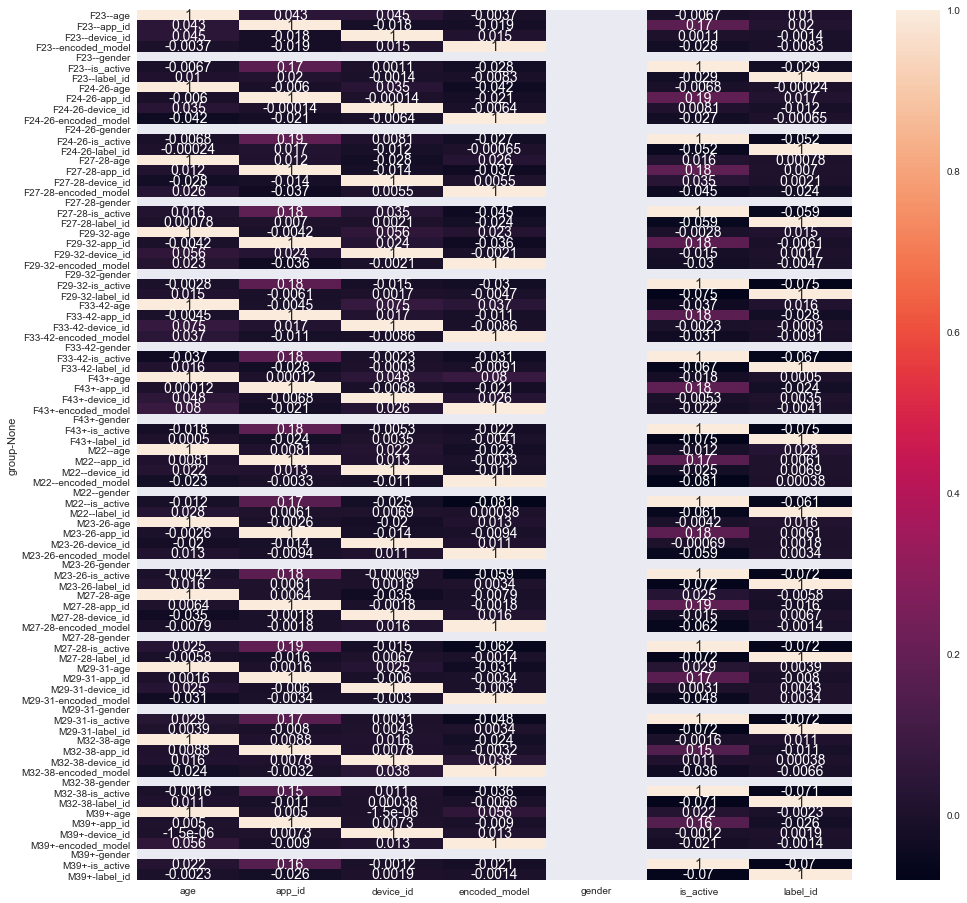

In [25]:
# Create a heatmap to see if there is any multicollinearity.
# Make a smaller data set to use because 7 million rows took too long.
group_data_mini = ga_apps_labeled_brands2[:600000]

# Group by group since that's the output that we care about.
group_data_mini = group_data_mini.groupby('group')

plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.rcParams.update({'font.size': 14})
sns.heatmap(group_data_mini.corr(), annot=True);

From the heat map, we can see that there is low multicollinearity between the different features and the group that we want to identify. The extremely low numbers are a sign that this data will be hard to model since it means that on the surface, the information presented don't have any relation.

# Creating Dummies

Creating dummies is the method that I want to use to utilize the app labels since the number of unique apps is less than the number of unique phone brands/companies. The reason I chose to encode phone brands is due to the volume of phones presented which would dilute the correlation of the features even more. Using dummies for the app labels will hopefully give more insight into the data at hand. 

In [26]:
# Convert label_id into a continuous variable
# even though it's numerical, it hasn't been standardized 
type_dummies = pd.get_dummies(ga_apps_labeled_brands['label_id'])

# Concatenate the dummies with the original data set.
ga_apps_labeled_brands = pd.concat([ga_apps_labeled_brands, type_dummies], axis=1)

print(ga_apps_labeled_brands.shape)

ga_apps_labeled_brands.head()

(7034111, 493)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,713,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,704,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,548,0,0,...,0,0,0,0,0,0,0,0,0,0
6,8761770737926125955,0,22,F23-,4287147352639325907,0,226,713,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8761770737926125955,0,22,F23-,4287147352639325907,0,226,704,0,0,...,0,0,0,0,0,0,0,0,0,0


# Addressing Class Imbalance

Below, we can see that after merging all of the different files together, there were more than 7 million rows! In an effort to conserve calculation time, I decided to downsample the data and also to remedy the class imbalance that my data is facing. It's important to address class imbalance due to the fact that I don't want my model to only be accurate at identifying the dominant class.

In [27]:
# Take a look at the distribution of the group values.
ga_apps_labeled_brands.group.value_counts()

M32-38    1185421
M39+      1107632
M23-26     817660
M29-31     810956
M27-28     530780
F33-42     517420
M22-       490009
F43+       391188
F29-32     368450
F23-       303034
F24-26     265262
F27-28     246299
Name: group, dtype: int64

In [28]:
# Downsampling the gender/age training set to 50000.
ga_m_youngest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M22-']
ga_m_younger = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M23-26']
ga_m_young = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M27-28']
ga_m_old = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M29-31']
ga_m_older = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M32-38']
ga_m_oldest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M39+']
ga_f_youngest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F23-']
ga_f_younger = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F24-26']
ga_f_young = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F27-28']
ga_f_old = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F29-32']
ga_f_older = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F33-42']
ga_f_oldest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F43+']

# Downsample majority class
ga_m_older_downsampled = resample(ga_m_older, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_m_oldest_downsampled = resample(ga_m_oldest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_m_younger_downsampled = resample(ga_m_younger, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_m_youngest_downsampled = resample(ga_m_youngest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)  
 
ga_m_old_downsampled = resample(ga_m_old, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_f_older_downsampled = resample(ga_f_older, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_m_young_downsampled = resample(ga_m_young, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_f_youngest_downsampled = resample(ga_f_youngest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_f_old_downsampled = resample(ga_f_old, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_f_oldest_downsampled = resample(ga_f_oldest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)


ga_f_younger_downsampled = resample(ga_f_younger, 
                                 replace=True,     # sample with replacement
                                n_samples=50000)

ga_f_young_downsampled = resample(ga_f_young, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

# Combine downsampled majority class 
ga_apps_labeled_brands_resampled = pd.concat([ga_m_younger_downsampled, ga_m_older_downsampled,
                               ga_m_oldest_downsampled, ga_m_youngest_downsampled,
                               ga_m_old_downsampled, ga_f_older_downsampled,
                               ga_m_young_downsampled, ga_f_youngest_downsampled,
                               ga_f_old_downsampled, ga_f_oldest_downsampled,
                               ga_f_younger_downsampled, ga_f_young_downsampled])
 
# Display new class counts
ga_apps_labeled_brands_resampled.group.value_counts()

F43+      50000
M22-      50000
F23-      50000
F33-42    50000
M29-31    50000
M23-26    50000
F24-26    50000
M27-28    50000
F29-32    50000
M32-38    50000
M39+      50000
F27-28    50000
Name: group, dtype: int64

In [29]:
# Shape
print(ga_apps_labeled_brands_resampled.shape)

# Head
ga_apps_labeled_brands_resampled.head()

(600000, 493)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
9521049,3157067638012012187,1,24,M23-26,5190837081340518879,0,558,302,0,0,...,0,0,0,0,0,0,0,0,0,0
12285138,-1351462401524912611,1,24,M23-26,2887917423598475134,0,857,775,0,0,...,0,0,0,0,0,0,0,0,0,0
5269642,-729061070712766363,1,24,M23-26,4244331088397413857,0,236,704,0,0,...,0,0,0,0,0,0,0,0,0,0
12763113,-3710894276888499361,1,24,M23-26,7318956472058153296,1,731,405,0,0,...,0,0,0,0,0,0,0,0,0,0
12917432,584364271345729137,1,23,M23-26,-4866707337108514028,0,121,548,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train Test Split

In [30]:
# Create X and y 
X = ga_apps_labeled_brands_resampled.drop(['group', 'app_id'], axis=1)
Y = ga_apps_labeled_brands_resampled['group'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

# Modeling

In [126]:
lr2 = LogisticRegression(C=2, max_iter=1000, multi_class='multinomial', solver='lbfgs')

lr2.fit(X_train, y_train)

lr2.score(X_train, y_train)

0.08616444444444445

In [127]:
cross_val_score(lr2, X_train, y_train, cv=5)

array([0.08691739, 0.08606667, 0.08568984, 0.08668985, 0.0854584 ])

In [128]:
# Classify, storing the result in a new variable.
lr2_pred = lr2.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, lr2_pred)

array([[   0, 6135,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6294],
       [   0, 6633,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6027],
       [   0, 6244,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6205],
       [   0, 6118,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6386],
       [   0, 6105,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6416],
       [   0, 6080,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6468],
       [   0, 6193,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6273],
       [   0, 6112,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6258],
       [   0, 6388,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6251],
       [   0, 6213,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6207],
       [   0, 6241,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6209],
       [   0, 6080,  

In [129]:
# Create a classification report.
print(classification_report(y_test, lr2_pred))

             precision    recall  f1-score   support

       F23-       0.00      0.00      0.00     12429
     F24-26       0.09      0.52      0.15     12660
     F27-28       0.00      0.00      0.00     12449
     F29-32       0.00      0.00      0.00     12504
     F33-42       0.00      0.00      0.00     12521
       F43+       0.00      0.00      0.00     12548
       M22-       0.00      0.00      0.00     12466
     M23-26       0.00      0.00      0.00     12370
     M27-28       0.00      0.00      0.00     12639
     M29-31       0.00      0.00      0.00     12420
     M32-38       0.00      0.00      0.00     12450
       M39+       0.09      0.52      0.15     12544

avg / total       0.01      0.09      0.03    150000



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Analysis 

The performance of this model was less than ideal. Furthermore, due to the fact that my model was inaccurate rather than overfitting, I couldn't use any of the regularization techniques to remedy the situation. I set the logistic parameters so that it would be more ideal for multi class identification, but the improvements were minimal.

The reason that this wasn't able to perform strongly enough is due to a multitude of reasons, including the large amount of features that were part of the equation, the large amount of classes it had to predict, and the low multicollinearity of the data. 

Below, I will try to use PCA to extract more information and consolidate the amount of parameters that this model has to estimate. 

# PCA Train/ Test Split

In [26]:
# Prepare the data first for PCA

# Instantiate StandardScaler
ss = StandardScaler()

# Set up the variables.
prep_X = ga_apps_labeled_brands_resampled.drop(['group', 'app_id'], axis=1)
prep_y = ga_apps_labeled_brands_resampled['group'].values.ravel()

# Standarize and fit the data first 
stand_x = ss.fit_transform(prep_X)

In [27]:
# Use 4 components since it will explain most of the variance.
pca = PCA(n_components=4)

# Create a new training and testing set
X_train2, X_test2, y_train2, y_test2 = train_test_split(stand_x, prep_y, test_size=0.3)

# Fit and transform training and testing dataset with PCA
X_train_pca = pca.fit_transform(X_train2)
X_test_pca = pca.fit_transform(X_test2)

In [134]:
# PCA logistic regression
lr = LogisticRegression()

# Use GS-CV to see which alpha level is best.
parameters = {
             'C':[0.000001,.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000],
             'multi_class':['multinomial'],
             'solver':['lbfgs'],
             'max_iter':[100,500,1000,1500,2000]}

lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1, n_jobs=-1)

#Fit the logistic regression 
lr_grid.fit(X_train_pca, y_train2)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  9.4min finished


Best parameters:
{'C': 10000, 'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Best Score:
0.15940714285714286


In [135]:
# Set up best parameters
lr3 = LogisticRegression(C=10000, max_iter=100, multi_class='multinomial', solver='lbfgs')

# Fit the model
lr3.fit(X_train_pca, y_train2)

# Cross validation.
cross_val_score(lr3, X_train_pca, y_train2, cv=5)

array([0.15970858, 0.1576272 , 0.16276993, 0.15695612, 0.1599619 ])

In [136]:
# Classify, storing the result in a new variable.
lr_pred = lr3.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, lr_pred)

array([[    1,     2,    69,  2746,     3,     5,    10,  1822,   782,
         9576,     1,     8],
       [    1,     0,    67,  3906,     5,     4,     6,  1322,   610,
         9111,     2,     6],
       [    1,     0,    83,  4320,     1,    10,     2,  1251,   551,
         8828,     0,     4],
       [    1,     0,   105,  4794,     2,    13,     4,  1086,   454,
         8434,     0,     9],
       [    0,     0,    76,  6521,     1,     6,     3,   678,   252,
         7476,     0,     4],
       [    0,     0,   127, 10016,     2,     7,     1,   227,    80,
         4475,     0,     1],
       [    1,     4,    75,  3460,     2,    10,     3,   498,  1355,
         9715,     0,     9],
       [    0,     2,    50,  4296,     7,    10,     4,   365,   950,
         9359,     1,     7],
       [    0,     0,    32,  4986,     5,    10,     3,   266,   730,
         8919,     0,     6],
       [    0,     0,    39,  5594,     3,     3,     1,   239,   625,
         8388,     0

In [137]:
# Create a classification report.
print(classification_report(y_test2, lr_pred))

             precision    recall  f1-score   support

       F23-       0.20      0.00      0.00     15025
     F24-26       0.00      0.00      0.00     15040
     F27-28       0.10      0.01      0.01     15051
     F29-32       0.07      0.32      0.12     14902
     F33-42       0.02      0.00      0.00     15017
       F43+       0.07      0.00      0.00     14936
       M22-       0.07      0.00      0.00     15132
     M23-26       0.05      0.02      0.03     15051
     M27-28       0.11      0.05      0.07     14957
     M29-31       0.09      0.56      0.15     14894
     M32-38       0.00      0.00      0.00     14995
       M39+       0.06      0.00      0.00     15000

avg / total       0.07      0.08      0.03    180000



# Analysis

The results of the logistic model has increased 100% after using PCA as a feature selection method and using Grid Search CV to find the optimal parameters. Unfortunately, 100% of 8 is still 8, so the improvement is only minimal. The reason that this model fails to perform is due to the fact that there wasn't much variance that this data could explain on its own. 

# KNN Model

In [36]:
# Instantiate StandardScaler
ss = StandardScaler()

# Set up the variables.
# Set up variables
X = ga_apps_labeled_brands_resampled.drop(['group', 'encoded_model'], axis=1)
ky = ga_apps_labeled_brands_resampled['group'].values.ravel()

# Standarize the data first 
ss.fit(X,ky)

# Now that the data is ready
transform_x = ss.transform(X, ky)

# Create training and testing set for knn
knn_Xtrain, knn_Xtest, knn_ytrain, knn_ytest = train_test_split(transform_x, ky, test_size=0.3)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:675: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


In [43]:
# Model took too long to run, so I'm limiting the size again.
# 420,000 rows after 4 hours, still no progress.
knn_Xtrain2 = knn_Xtrain[:100000]
knn_ytrain2 = knn_ytrain[:100000]

print(knn_Xtrain2.shape)

(100000, 491)


In [45]:
from sklearn.neighbors import KNeighborsClassifier
# Initialize the model
knn = KNeighborsClassifier()


knn_params = {'n_neighbors':[2,4,5,7,9,10,12,14,20,30]}

# Set up parameters
knn_grid = GridSearchCV(knn, knn_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
knn_grid.fit(knn_Xtrain2, knn_ytrain2)

# Return best parameters and best score
print('Best parameters:')
print(knn_grid.best_params_)
print('Best Score:')
print(knn_grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 591.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 779.0min finished


Best parameters:
{'n_neighbors': 4}
Best Score:
0.39114


# Analysis of KNN 

For knn, I first standardized the data so that everything would be at the correct distance. I used grid search to search for the optimal parameters, but it took almost 24 hours to complete only to return such a low accuracy score. Furthermore, I had used only a smaller sample of the data set in order to speed up the process but it still took so long so I judged that it wasn't worth the effort to fine tune this model further. 

This is a steady improvement from the previous model and improvement continues. 

# Random Forest with and without different Feature Selection Methods

In [149]:
# Setup random forest classifier.
rfc = RandomForestClassifier(n_estimators=1000, max_features=8,
                            max_depth=8, n_jobs=-1)

# Fit the model
rfc.fit(X_train, y_train)

# Score of the model
rfc.score(X_train, y_train)

0.9403066666666666

In [150]:
# Cross validation.
cross_val_score(rfc, X_train, y_train, cv=5)

array([0.93618061, 0.94454568, 0.92583416, 0.91045357, 0.94204122])

In [151]:
# Classify, storing the result in a new variable.
rfc_pred = rfc.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, rfc_pred)

array([[11240,  1384,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [  378, 12042,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    1,     0, 12414,     5,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0,    10, 12010,   159,   428,     0,     0,     0,
            0,     0,     0],
       [    0,     1,    12,  1665,  9556,  1419,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     6,   986,   247, 11142,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0, 11534,   863,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,   555, 11879,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     1,     1, 12361,
            1,     1,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
        12516,    63

In [152]:
# Create a classification report.
print(classification_report(y_test, rfc_pred))

             precision    recall  f1-score   support

       F23-       0.97      0.89      0.93     12624
     F24-26       0.90      0.97      0.93     12420
     F27-28       1.00      1.00      1.00     12420
     F29-32       0.82      0.95      0.88     12607
     F33-42       0.96      0.76      0.85     12653
       F43+       0.86      0.90      0.88     12381
       M22-       0.95      0.93      0.94     12397
     M23-26       0.93      0.96      0.94     12434
     M27-28       1.00      1.00      1.00     12365
     M29-31       0.96      0.99      0.98     12592
     M32-38       0.86      0.97      0.91     12446
       M39+       0.99      0.84      0.91     12661

avg / total       0.93      0.93      0.93    150000



# Feature-less Analysis

This is an ensemble method which means that this model is a conglomeration of weak learners, or in this case, 1000 trees. It's no surprise that this model did well due to the fact that given a deeper death, and more runs, this allows the model to know more about the dataset. Given more depth and features, the model can lower entropy from the data set that I fed it and accurately classify the data. 

In [56]:
# Feature Selection - SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.feature_selection import VarianceThreshold

# Instantiate models and pipelines.
kbest = SelectKBest(f_classif)
# Remove the 0 variance features b/c f_classif doesn't like dividing by 0
VT = VarianceThreshold()
rfc_pipeline = Pipeline([('vt', VT), ('kbest', kbest), ('rfc', ensemble.RandomForestClassifier())])

# Create rfc parameters for GS-CV
param_grid = {'kbest__k': [3,4,5,6,7,8,9,10,11,12],
              'vt__threshold':[0],
              'rfc__n_estimators': [1500],
             'rfc__max_depth': [16]}

# Set up GS-CV
rfc_grid = GridSearchCV(rfc_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the model.
rfc_grid.fit(X_train, y_train)

# Show the best parameter and best score for unfiltered
print('Best Parameter for data:', rfc_grid.best_params_)
print('\nBest Score for data:', rfc_grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 148.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 189.6min finished


Best Parameter for data: {'kbest__k': 12, 'rfc__max_depth': 16, 'rfc__n_estimators': 1500, 'vt__threshold': 0}

Best Score for data: 0.56202


In [57]:
# Set up the best parameters. Increase k
best_param = {'kbest__k': [15],'rfc__max_depth': [16],
              'rfc__n_estimators':[1500], 'vt__threshold':[0]}

# Set up a new grid
best_rfc_grid = GridSearchCV(rfc_pipeline, best_param, cv=5, verbose=1, n_jobs=-1)

# Cross Validate the random forest model.  
cross_val_score(best_rfc_grid, X_train, y_train, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.2min remaining: 21.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.1min remaining: 19.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.2min remaining: 19.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.5min remaining: 20.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.0min remaining: 21.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.9min finished


array([0.5642131 , 0.56385414, 0.56175069, 0.56171248, 0.61859416])

In [59]:
# Fit our model to the data.
best_rfc_grid.fit(X_train, y_train)

# Classify, storing the result in a new variable.
k_rfc_pred = best_rfc_grid.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, k_rfc_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 19.2min remaining: 28.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.4min finished


array([[ 3754,     0,     0,     0,     0,     0,  8112,   702,     0,
            0,     0,     0],
       [    0, 10438,     0,     0,     0,     0,     0,  2092,     0,
            0,     0,     0],
       [    0,     0,  6903,     0,     0,     0,     0,     0,  5600,
            0,     0,     0],
       [    0,     0,     0,  3296,     0,     0,     0,     0,     0,
         8216,   978,     0],
       [    0,     0,     0,     0,  3959,     0,     0,     0,     0,
            0,  6281,  2209],
       [    0,     0,     0,     0,     0, 12073,     0,     0,     0,
            0,     0,   418],
       [ 1555,     0,     0,     0,     0,     0, 10934,     0,     0,
            0,     0,     0],
       [ 1577,  7779,     0,     0,     0,     0,     0,  3284,     0,
            0,     0,     0],
       [    0,     0,  5788,     0,     0,     0,     0,     0,  6630,
            0,     0,     0],
       [    0,     0,     0,  1576,     0,     0,     0,     0,     0,
        10773,     0

In [60]:
# Create a classification report.
print(classification_report(y_test, k_rfc_pred))

             precision    recall  f1-score   support

       F23-       0.55      0.30      0.39     12568
     F24-26       0.57      0.83      0.68     12530
     F27-28       0.54      0.55      0.55     12503
     F29-32       0.54      0.26      0.35     12490
     F33-42       0.53      0.32      0.40     12449
       F43+       0.61      0.97      0.75     12491
       M22-       0.57      0.88      0.69     12489
     M23-26       0.54      0.26      0.35     12640
     M27-28       0.54      0.53      0.54     12418
     M29-31       0.57      0.87      0.69     12349
     M32-38       0.56      0.74      0.64     12497
       M39+       0.56      0.26      0.36     12576

avg / total       0.56      0.56      0.53    150000



# SKB Analysis

In this model, I made the mistake of not including more features to be used which lead to the accuracy of the model decreasing.

In [143]:
# Instantiate model
rfc2 = ensemble.RandomForestClassifier()

# Create rfc parameters for GS-CV
param_grid = {'n_estimators': [100, 200, 500, 800, 1000],
             'max_depth': [2, 4, 6, 8]}

# Set up GS-CV
grid = GridSearchCV(rfc2, param_grid, cv=5, verbose=1, n_jobs=-1)

grid.fit(X_train_pca, y_train2)

# Show the best parameter and best score for unfiltered
print('Best Parameter for data:', grid.best_params_)
print('\nBest Score for data:', grid.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 119.5min finished


Best Parameter for data: {'max_depth': 8, 'n_estimators': 500}

Best Score for data: 0.4088880952380952


In [195]:
# Implement different parameters
rfc3 = ensemble.RandomForestClassifier(n_estimators=1000, max_features='auto',
                                     max_depth=12, n_jobs=-1)

rfc3.fit(X_train_pca, y_train2)

rfc3.score(X_train_pca, y_train2)

0.7292190476190477

In [196]:
# Cross Validate the random forest model.  
cross_val_score(rfc3, X_train_pca, y_train2, cv=5)

array([0.67828913, 0.67969001, 0.68153951, 0.68094478, 0.68259638])

In [197]:
# Fit our model to the data.
rfc3.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
rfc_pred2 = rfc3.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, rfc_pred2)

array([[    5,     4,     0,     0,     1,     9,     8,     0,     0,
            0,     1, 15062],
       [    3,     0,     1,     0,     0,     5,     5,     1,     0,
            0,     3, 15079],
       [    4,     2,     1,     0,     0,     5,    10,     2,     0,
            0,     1, 14926],
       [    5,     1,     0,     0,     0,     7,     7,     0,     0,
            0,     3, 14848],
       [    7,     4,     2,     0,     0,     6,    12,     1,     0,
            0,     2, 14933],
       [    3,     0,     0,     0,     0,    66,     8,     0,     0,
            0,     1, 14993],
       [    6,     2,     3,     0,     0,     5,    23,     0,     0,
            3,     5, 15021],
       [    4,     2,     1,     0,     0,     5,    11,     0,     0,
            1,     5, 14945],
       [    5,     3,     3,     0,     0,     3,    10,     0,     0,
            0,     2, 14971],
       [    3,     5,     2,     0,     0,     9,    11,     0,     0,
            0,     4

In [198]:
# Create a classification report.
print(classification_report(y_test2, rfc_pred2))

             precision    recall  f1-score   support

       F23-       0.09      0.00      0.00     15090
     F24-26       0.00      0.00      0.00     15097
     F27-28       0.06      0.00      0.00     14951
     F29-32       0.00      0.00      0.00     14871
     F33-42       0.00      0.00      0.00     14967
       F43+       0.45      0.00      0.01     15071
       M22-       0.18      0.00      0.00     15068
     M23-26       0.00      0.00      0.00     14974
     M27-28       0.00      0.00      0.00     14997
     M29-31       0.00      0.00      0.00     14980
     M32-38       0.16      0.00      0.00     14956
       M39+       0.08      1.00      0.15     14978

avg / total       0.09      0.08      0.01    180000



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# PCA Analysis

PCA is a dimension reductionality techique. It will create new independent features that explain the majority of the variance of the data set. However, there will still be a bit of data loss included in the data set. I did not anticipate that using PCA would worsen the predictive capability of my model. However, I increased the amount of depth in order to lower the entropy of the model and increase it's predictive accuracy.

# X Gradient Boosting Model

In [61]:
# X-Gradient boosted model
clf = XGBClassifier(max_depth=5, reg_alpha=5000, reg_lambda=5000)

# Fit the model.
clf.fit(X_train, y_train)

# Look at the score.
clf.score(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1.0

In [63]:
# Create a mini data set since no amount of inhibition will work.
Xtr_mini = X_train[:100000]
ytr_mini = y_train[:100000]

In [69]:
# X-Gradient boosted model
clf = XGBClassifier(max_depth=5, reg_alpha=4500, reg_lambda=5000)

# Fit the model.
clf.fit(Xtr_mini, ytr_mini)

# Look at the score.
clf.score(Xtr_mini, ytr_mini)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.91751

In [74]:
# Cross Validate the model. 
cross_val_score(clf, Xtr_mini, ytr_mini, cv=5)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

array([0.75012499, 0.75012499, 0.75012499, 0.75012501, 0.75015003])

In [71]:
# Classify, storing the result in a new variable.
clf_pred = clf.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, clf_pred)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[12571,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0, 12698,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0, 12555,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0, 12516,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0, 12353,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0, 12495,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0, 12382,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0, 12438,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0, 12550,
            0,     0,     0],
       [    0,     0, 12401,     0,     0,     0,     0,     0,     0,
            0,     0

In [73]:
# Create a classification report.
print(classification_report(y_test, clf_pred))

             precision    recall  f1-score   support

       F23-       1.00      1.00      1.00     12571
     F24-26       1.00      1.00      1.00     12698
     F27-28       0.50      1.00      0.67     12555
     F29-32       1.00      1.00      1.00     12516
     F33-42       1.00      1.00      1.00     12353
       F43+       1.00      1.00      1.00     12495
       M22-       1.00      1.00      1.00     12382
     M23-26       1.00      1.00      1.00     12438
     M27-28       1.00      1.00      1.00     12550
     M29-31       0.00      0.00      0.00     12401
     M32-38       1.00      1.00      1.00     12581
       M39+       1.00      1.00      1.00     12460

avg / total       0.88      0.92      0.89    150000



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Analysis 

First, I would like to state that I used XGB instead of regular gradient boosting because gradient boosting took too long and wasn't as accurate as XGB. The reason that it is faster is due to XGB's ability to parallel process which regular gradient boosting cannot do. 

Overfitting of XGB had occurred when I used the full data set since there was just so much data for it to learn from. I used the regularization method to inhibit the growth of the parameters, but it still wasn't enough. 

Afterwards, I used a smaller data set to achieve quicker results and to reduce overfitting of the model. XGB uses stochastic gradient descent which is an implementation of L1 and L2 regularization in order to help reduce the cost function and obtain the best score. Alpha is L1 (Lasso Regression), and lambda is L2 (Ridge Regression). Alpha was a strong regularization parameter since it just got rid of features that didn't pass its threshold. However, at its core XGB is just like GB since they are both an ensemble model that learns iteratively from the residual errors (boosting) instead of learning via bagging.

The precision and recall of the results are both at an acceptable level, but it seems to be not as accurate when it comes to identifying young adult females, and fails to identify young adult men completely, but that is due to the fact that I took a sample of my training data set which may not have contained such individuals. 

In [219]:
# X-Gradient boosted model with PCA
clf2 = XGBClassifier(max_depth=12)

clf2.fit(X_train_pca, y_train2)

clf2.score(X_train_pca, y_train2)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9398214285714286

In [222]:
# Cross Validate the model. 
cross_val_score(clf2, X_train_pca, y_train2, cv=5)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

array([0.83166278, 0.83106556, 0.83185914, 0.83221029, 0.83144034])

In [224]:
# Classify, storing the result in a new variable.
clf2_pred = clf2.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, clf2_pred)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[    2,     2,     3,     0,    11,    11,     7,     1,     0,
            0,     1, 15052],
       [    4,     0,     1,     0,    12,     9,     4,     1,     0,
            0,     4, 15062],
       [    6,     1,     2,     0,    17,     9,     6,     2,     0,
            0,     1, 14907],
       [    4,     1,     0,     0,    15,     8,     3,     3,     0,
            0,     3, 14834],
       [    2,     0,     0,     0,    16,     8,    11,     2,     0,
            0,     3, 14925],
       [   23,    29,     6,     2,    18,   191,     6,     1,     0,
           20,     2, 14773],
       [    2,     0,     1,     0,    19,    11,    23,     0,     0,
            0,     6, 15006],
       [    2,     1,     2,     0,    20,     8,     9,     1,     0,
            0,     6, 14925],
       [    3,     0,     2,     0,    21,     6,     5,     0,     0,
            0,     3, 14957],
       [    2,     0,     1,     0,    26,     8,     6,     0,     0,
            0,     4

In [225]:
# Create a classification report.
print(classification_report(y_test2, clf2_pred))

             precision    recall  f1-score   support

       F23-       0.03      0.00      0.00     15090
     F24-26       0.00      0.00      0.00     15097
     F27-28       0.10      0.00      0.00     14951
     F29-32       0.00      0.00      0.00     14871
     F33-42       0.07      0.00      0.00     14967
       F43+       0.55      0.01      0.02     15071
       M22-       0.24      0.00      0.00     15068
     M23-26       0.08      0.00      0.00     14974
     M27-28       0.00      0.00      0.00     14997
     M29-31       0.00      0.00      0.00     14980
     M32-38       0.15      0.00      0.00     14956
       M39+       0.08      0.99      0.15     14978

avg / total       0.11      0.08      0.02    180000



# XGB with PCA Analysis

The score after using PCA increased. I only needed to increase the depth level in order for the model to learn more specifically which made up for some of the variance loss that the PCA incurred. I didn't even need to increase the regularization parameters in order to remedy the overfitting since PCA already took care of it. 

However, it seems that after PCA is used, the classifcation report score will always decrease which is something to be careful of. 

# Deep Learning Models

In [41]:
import tensorflow as tf
import keras

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D 
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, Adam
from keras.utils import np_utils
from keras.utils import to_categorical

# Import the backend
from keras import backend as K

In [53]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
ytr_int_encoded = label_encoder.fit_transform(y_train2)
yte_int_encoded = label_encoder.fit_transform(y_test2)

In [58]:
# Start with a simple sequential model.
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(1024, activation='relu', input_shape=(4,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.3))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(12, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 1024)              5120      
_________________________________________________________________
dropout_43 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_45 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 64)                4160      
__________

In [61]:
history = model.fit(X_train_pca, ytr_int_encoded,
                    batch_size=150,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_test_pca, yte_int_encoded))
score = model.evaluate(X_test_pca, yte_int_encoded, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 420000 samples, validate on 180000 samples
Epoch 1/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3301 - acc: 0.5214 - val_loss: 8.5426 - val_acc: 0.0835
Epoch 2/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3291 - acc: 0.5206 - val_loss: 8.7356 - val_acc: 0.0833
Epoch 3/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3296 - acc: 0.5205 - val_loss: 8.8799 - val_acc: 0.0843
Epoch 4/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3308 - acc: 0.5192 - val_loss: 8.7041 - val_acc: 0.0832
Epoch 5/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3303 - acc: 0.5197 - val_loss: 8.3386 - val_acc: 0.0844
Epoch 6/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3289 - acc: 0.5215 - val_loss: 8.7422 - val_acc: 0.0849
Epoch 7/200
420000/420000 [==============================] - 22s 53us/step - loss: 1.3303 - acc: 0.520

420000/420000 [==============================] - 22s 52us/step - loss: 1.3188 - acc: 0.5252 - val_loss: 8.8896 - val_acc: 0.0862
Epoch 59/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3176 - acc: 0.5246 - val_loss: 8.3193 - val_acc: 0.0857
Epoch 60/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3173 - acc: 0.5250 - val_loss: 8.5780 - val_acc: 0.0854
Epoch 61/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3180 - acc: 0.5255 - val_loss: 8.9466 - val_acc: 0.0858
Epoch 62/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3195 - acc: 0.5250 - val_loss: 8.5938 - val_acc: 0.0851
Epoch 63/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3173 - acc: 0.5262 - val_loss: 8.9252 - val_acc: 0.0850
Epoch 64/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3198 - acc: 0.5249 - val_loss: 8.8291 - val_acc: 0.0861
Epoch 65/200
420000

420000/420000 [==============================] - 22s 52us/step - loss: 1.3034 - acc: 0.5309 - val_loss: 8.4951 - val_acc: 0.0828
Epoch 116/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3040 - acc: 0.5308 - val_loss: 8.3035 - val_acc: 0.0849
Epoch 117/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3038 - acc: 0.5299 - val_loss: 8.3912 - val_acc: 0.0845
Epoch 118/200
420000/420000 [==============================] - 22s 51us/step - loss: 1.3048 - acc: 0.5305 - val_loss: 8.3203 - val_acc: 0.0865
Epoch 119/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3046 - acc: 0.5312 - val_loss: 8.4597 - val_acc: 0.0831
Epoch 120/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3046 - acc: 0.5303 - val_loss: 8.8475 - val_acc: 0.0841
Epoch 121/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.3058 - acc: 0.5299 - val_loss: 8.5689 - val_acc: 0.0848
Epoch 122/200

420000/420000 [==============================] - 22s 52us/step - loss: 1.2927 - acc: 0.5350 - val_loss: 9.0782 - val_acc: 0.0832
Epoch 173/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.2904 - acc: 0.5352 - val_loss: 8.8976 - val_acc: 0.0845
Epoch 174/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.2902 - acc: 0.5367 - val_loss: 9.2084 - val_acc: 0.0842
Epoch 175/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.2897 - acc: 0.5365 - val_loss: 8.9439 - val_acc: 0.0867
Epoch 176/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.2877 - acc: 0.5375 - val_loss: 9.2426 - val_acc: 0.0829
Epoch 177/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.2899 - acc: 0.5362 - val_loss: 8.2083 - val_acc: 0.0824
Epoch 178/200
420000/420000 [==============================] - 22s 52us/step - loss: 1.2879 - acc: 0.5370 - val_loss: 8.7391 - val_acc: 0.0814
Epoch 179/200

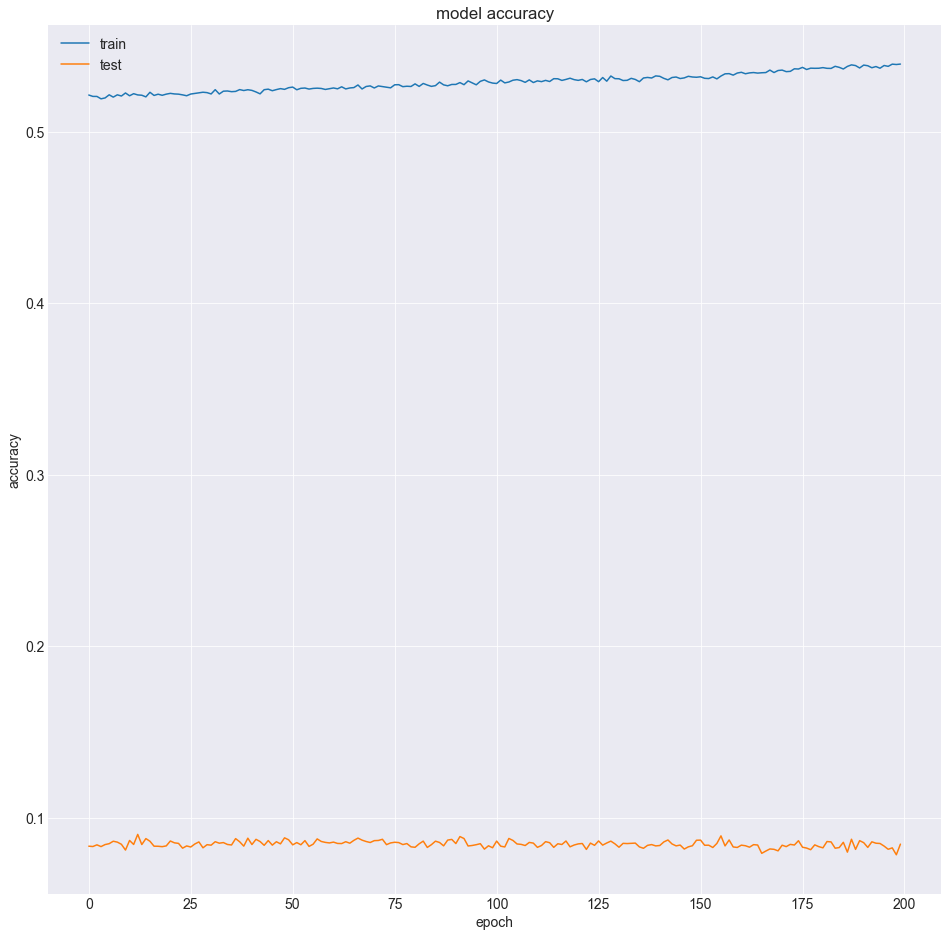

In [62]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Analyis

For my neural network, I initially had a lot of issues with it since I had to encode my test data in order to use the neural network because my test data was all strings. So I had the option of encoding it one-hot encoding or encoding it as integers. I chose the integer method in order to keep the column and reduce the number of columns that the hot encoding would have returned to me. Because I chose integers, I had to use sparse categorical crossentropy as my loss function which is meant for multiclass identification. 

Afterwards, I chose to use the PCA data set in order to obtain a better score. Ultimately, the neural network training score did alright after a few iterations (having more epochs), but the validation score had not improved.

# Convolutional Neural Network

In [72]:
train = ga_apps_labeled_brands_resampled
test = ga_apps_labeled_brands_resampled.drop('group', axis=1)

# Write a method to encode my data.
def encode(train, test):
    label_encoder = LabelEncoder().fit(ga_apps_labeled_brands_resampled.group)
    labels = label_encoder.transform(ga_apps_labeled_brands_resampled.group)
    classes = list(label_encoder.classes_)

    train = ga_apps_labeled_brands_resampled.drop(['group', 'app_id'], axis=1)
    test = ga_apps_labeled_brands_resampled.drop('group', axis=1)

    return train, labels, test, classes

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
# Run my method
train, labels, test, classes = encode(train, test)

# standardize train features
scaler = StandardScaler().fit(train.values)
scaled_train = scaler.transform(train.values)

# split train data into train and validation
sss = StratifiedShuffleSplit(test_size=0.1, random_state=23)
for train_index, valid_index in sss.split(scaled_train, labels):
    cnn_X_train, cnn_X_test = scaled_train[train_index], scaled_train[valid_index]
    cnn_y_train, cnn_y_test = labels[train_index], labels[valid_index]
    

nb_features = 491 # number of features   
nb_class = len(classes)

# reshape train data
X_train_r = np.zeros((len(cnn_X_train), nb_features, 491))
X_train_r[:, :, 0] = cnn_X_train[:, :nb_features]
X_train_r[:, :, 1] = cnn_X_train[:, nb_features:155]
X_train_r[:, :, 2] = cnn_X_train[:, 155:]

# reshape validation data
X_test_r = np.zeros((len(cnn_X_test), nb_features, 491))
X_test_r[:, :, 0] = cnn_X_test[:, :nb_features]
X_test_r[:, :, 1] = cnn_X_test[:, nb_features:155]
X_test_r[:, :, 2] = cnn_X_test[:, 155:]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
cnn_y_train = np_utils.to_categorical(cnn_y_train, nb_class)
cnn_y_test = np_utils.to_categorical(cnn_y_test, nb_class)

In [ ]:
# Keras model with one Convolution1D layer
# unfortunately more number of covnolutional layers, filters and filters lenght 
# don't give better accuracy
model = Sequential()
model.add(Convolution1D(nb_filter=512, filter_length=1, input_shape=(nb_features, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(nb_class))
model.add(Activation('softmax'))


In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train_r, cnn_y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(X_test_r, cnn_y_test))
score = model.evaluate(X_test_r, cnn_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [69]:
# Building the Convolutionals Model
model = Sequential()

# Set up some parameters
num_classes = 12
input_shape = (490,)

# Convert X_train and X_test to numpy array
max_review_length = 500 
X_train_CNN = sequence.pad_sequences(X_train_pca, maxlen=max_review_length) 
X_test_CNN = sequence.pad_sequences(X_test_pca, maxlen=max_review_length)


# First convolutional layer, note the specification of shape
model.add(Conv1D(32, kernel_size=10,
                 activation='relu',
                 input_shape=input_shape))
model.add(Flatten())
model.add(Conv1D(128, activation='relu'))
model.add(Flatten())
model.add(MaxPooling1D(pool_size=20,))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train_pcaa, ytr_int_encoded,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test_pcaa, yte_int_encoded))
score = model.evaluate(X_test_pcaa, yte_int_encoded, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: Input 0 is incompatible with layer conv1d_9: expected ndim=3, found ndim=2

# Unsupervised Learning

In [38]:
print(X.shape)
X.head()

(600000, 490)


,device_id,gender,age,is_active,label_id,2,4,6,7,8,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
3181223,-5422222189097128376,1,23,0,710,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12465750,-1909840803012691378,1,23,0,719,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5864016,-3950380121994356121,1,25,0,549,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2574694,-691042505889609750,1,24,0,549,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2006630,-8010454263681268365,1,26,0,780,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Prepare for k-means X.
km_X = X_train
km_Xte = X_test
# Normalize
X_norm = normalize(km_X)
X_norm_test = normalize(km_Xte)

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
kmX_pca = pca.fit_transform(X_norm)
kmX_test_pca = pca.fit_transform(X_norm_test)

In [32]:
# Calulate predicted values
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42, n_init=20, n_jobs=-1)
y_pred = kmeans.fit_predict(kmX_pca)

pd.crosstab(y_train, y_pred)

col_0,0,1
row_0,,
F23-,18986,18516
F24-26,18067,19466
F27-28,18480,18928
F29-32,19246,18264
F33-42,19319,18193
F43+,19109,18427
M22-,18582,18914
M23-26,18928,18627
M27-28,18523,18896


In [155]:
from sklearn.metrics import adjusted_rand_score
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred)))

Adjusted Rand Score: 8.065058e-05


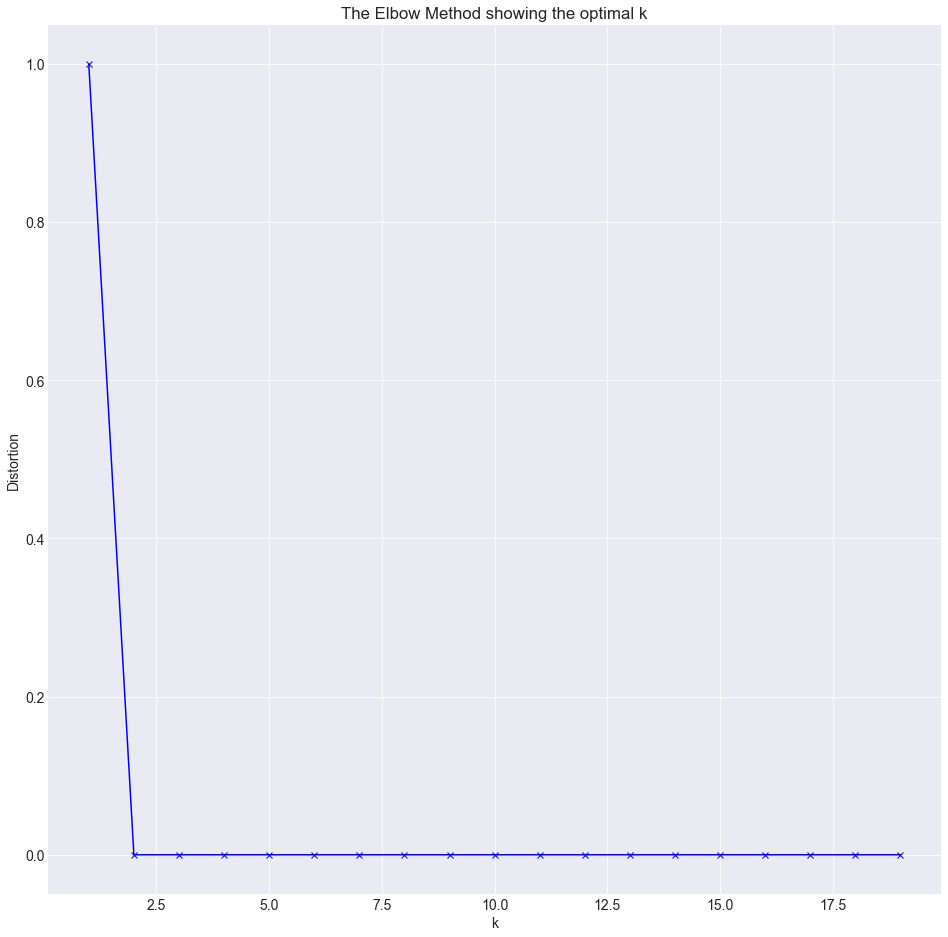

In [156]:
from scipy.spatial.distance import cdist
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(kmX_pca)
    kmeanModel.fit(kmX_pca)
    distortions.append(sum(np.min(cdist(kmX_pca, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / kmX_pca.shape[0])

# Plot the elbow
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [46]:
# Cluster Analysis
cluster_pred = KMeans(n_clusters=2, random_state=42, n_jobs=-1).fit_predict(X)
X_pred = X.copy()
X_pred['cluster_assignment'] = cluster_pred

cluster_dataframes = {}
for n_clust in range(3):
    cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

for name, frame in cluster_dataframes.items():
    print(name)
    print('\n')
    print(frame.describe())

0


          device_id    gender            age      is_active       label_id  \
count  3.037450e+05  303745.0  303745.000000  303745.000000  303745.000000   
mean  -4.552825e+18       1.0      31.384859       0.289341     586.524634   
std    2.674008e+18       0.0       9.740515       0.453457     239.637685   
min   -9.222957e+18       1.0      11.000000       0.000000       6.000000   
25%   -6.851784e+18       1.0      25.000000       0.000000     405.000000   
50%   -4.522266e+18       1.0      29.000000       0.000000     704.000000   
75%   -2.255756e+18       1.0      35.000000       1.000000     756.000000   
max    7.684152e+16       1.0      86.000000       1.000000    1021.000000   

              2         4              6              7              8  \
count  303745.0  303745.0  303745.000000  303745.000000  303745.000000   
mean        0.0       0.0       0.000020       0.000013       0.000211   
std         0.0       0.0       0.004444       0.003629       0.014514 

# K-means Analysis 

It is standard practice to standardize data and run PCA on the data set in order for k-means to function properly since, k-means concept is similar to knn in terms of distances and creating data points that aren't skewed by standarding them first. However, k-means have centroids where these data points will go to and form a cluster that will tell the user about what characteristics these clusters share.

The reason I chose to use two clusters is because I ran PCA on my data set and set the dimensions to 2 so the optimal amount of clusters should also be 2 as presented below using the elbow method. I chose n_init as 20 in order to try different centroid seeds in order to obtain the best output in terms of minimizing inertia or the sum of squared errors for each cluster (aka the cost function). 

In [33]:
# Turn the clusters into a data frame so that I can put it back
# in the data set. 
df_y = pd.DataFrame(y_pred)
df_y.columns = ['Cluster']
df_y.head()

,Cluster
0,1
1,0
2,0
3,1
4,0


In [34]:
# Attach clusters to the data frame.
clustered_x = X.join(df_y, how='inner')

clustered_x.head()

,device_id,gender,age,is_active,encoded_model,label_id,2,4,6,7,...,1013,1014,1015,1016,1017,1018,1019,1020,1021,Cluster
46,5500093691849381863,1,30,0,865,548,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46,5500093691849381863,1,30,0,865,548,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
176,-4863195921899852917,1,30,0,368,704,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,7064488711104523514,1,31,0,1461,704,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
314,-7409267423009514170,0,19,0,1659,704,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [35]:
# Create age method.

def age_bucket(age):
    output = ''
    if age <=20:
        output = 'Under 20'
    elif (age > 20 and age <= 30):
        output = 'Between 20 and 30'
    elif (age > 30 and age <= 40):
        output = 'Between 30 and 40'
    elif (age > 40 and age <= 50):
        output = 'Between 40 and 50'
    elif (age > 50 and age <= 60):
        output = 'Between 50 and 60'
    else:
        output = 'Over 60'
    
    return output

In [36]:
# Apply the method I just wrote. 
clustered_x['Age Bucket'] = clustered_x['age'].apply(lambda x: age_bucket(x))

Distribution of Age in Clusters


<Figure size 1152x576 with 0 Axes>

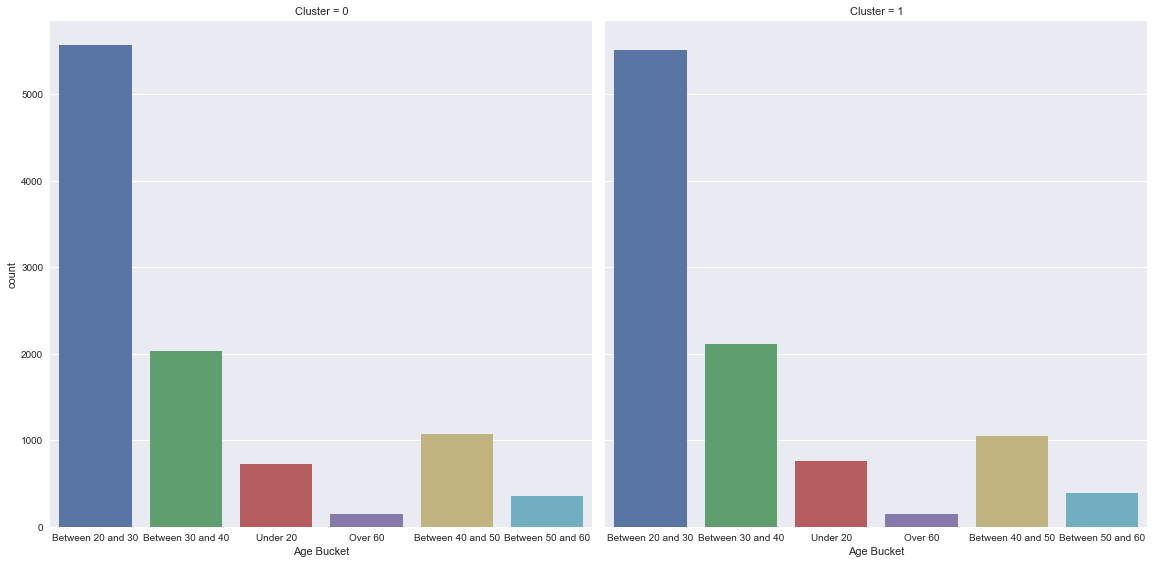

In [48]:
# Look at Age Breakdown for Count
plt.figure(figsize=(16,8))
print('Distribution of Age in Clusters')
sns.set(font_scale=1)
sns.factorplot(x='Age Bucket', col='Cluster', kind="count", data=clustered_x, size=8)
plt.show()

Distribution of Gender in Clusters:
0=females, 1=males


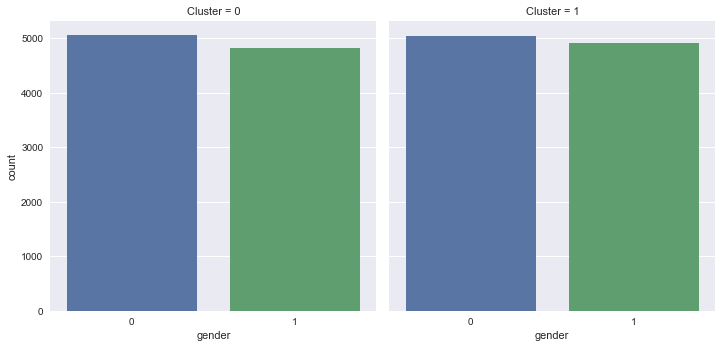

In [47]:
# Take a look at gender
print('Distribution of Gender in Clusters:')
print('0=females, 1=males')
sns.factorplot(x='gender', col='Cluster', kind="count", data=clustered_x, size=5)
plt.show()

Distribution of Clusters on whether User is Active or Not:
0=inactive, 1=active


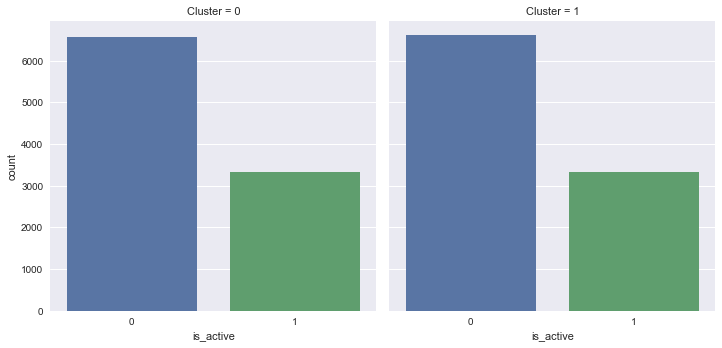

In [50]:
# Take a look at is_active
print('Distribution of Clusters on whether User is Active or Not:')
print('0=inactive, 1=active')
sns.factorplot(x='is_active', col='Cluster', kind="count", data=clustered_x, size=5)
plt.show()

# Current Issues.

- Improving the logistic classification model has proved difficult. I have applied PCA but to no avail.
- I applied PCA and selectKBest to the random forest model. Random forest improved .02% while selectKbest did not improve.
- Working on keras neural network now. 
- I have increased layers, batch size, and epochs already, but I'm still capped at 8% accuracy.
- Neural Network was able to work after using PCA data set. Could improve training score, but test score is still low.
- Need to encode target data in order to use it since neural network won't take string data. 
- Still have an error at the CNN. CNN still failing to run. 